# 导入

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\0\AppData\Local\Temp\ipykernel_3652\612648604.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geo_centroid'] = gdf.centroid


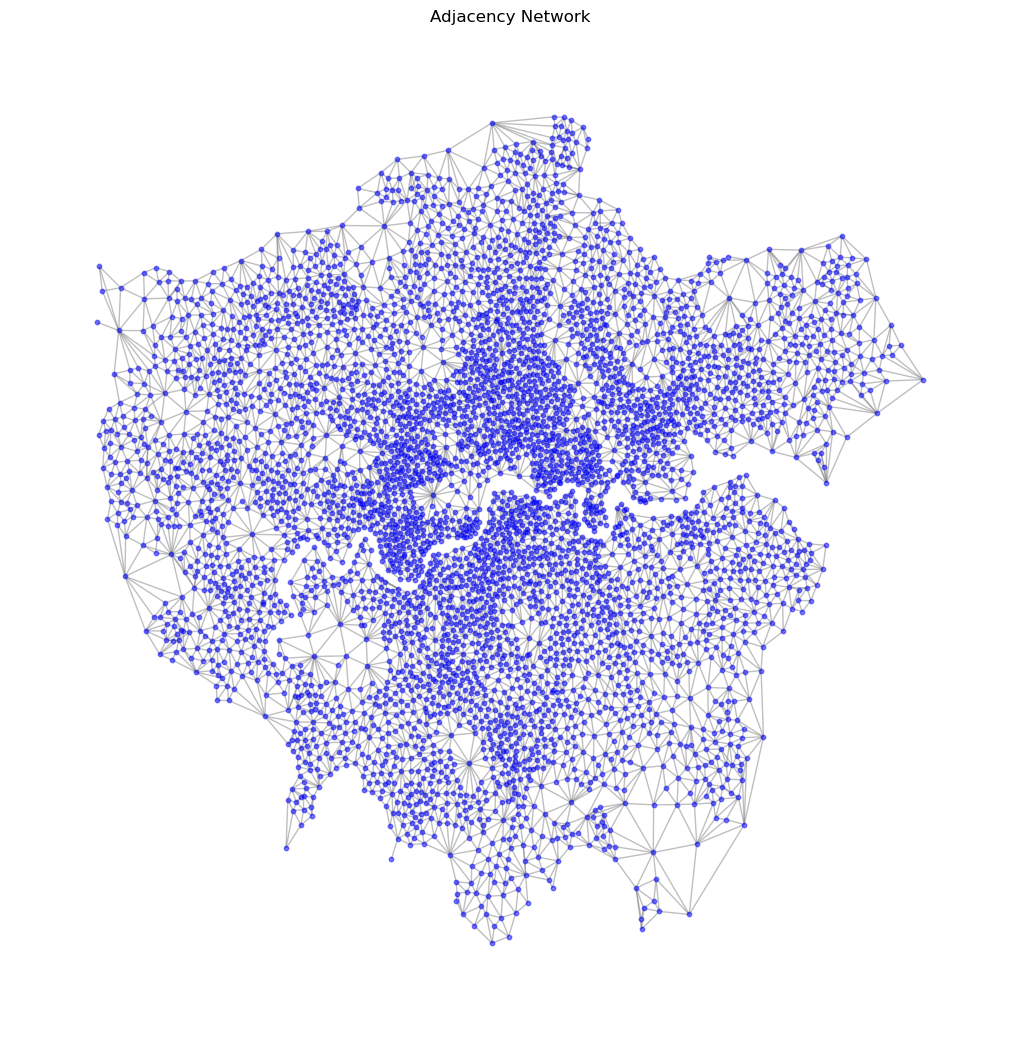

In [2]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 计算每个LSOA的几何中心点
gdf['geo_centroid'] = gdf.centroid

# 计算相邻关系
neighbors = gpd.sjoin(gdf, gdf, how='left', predicate='intersects')

# 手动处理索引
neighbors = neighbors[neighbors.index != neighbors.index_right]

# 构建邻接矩阵
G = nx.Graph()

# 添加节点
for idx, row in gdf.iterrows():
    G.add_node(idx, pos=(row.geo_centroid.x, row.geo_centroid.y))

# 添加边，根据相邻关系
for idx, row in neighbors.iterrows():
    G.add_edge(row.name, row['index_right'], weight=1)

# 可视化邻接关系
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_size=10, node_color='blue', edge_color='grey', alpha=0.5)
plt.title("Adjacency Network")
plt.show()

In [3]:
# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_NO2',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    # 'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    # 'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]

# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 使用邻接节点的均值填充空值
for i, row in fixed_features.iterrows():
    for col in fixed_columns:
        if pd.isna(row[col]):
            neighbor_indices = list(G.neighbors(i))
            if neighbor_indices:  # 确保有邻居
                neighbor_values = fixed_features.iloc[neighbor_indices][col]
                mean_value = neighbor_values.mean()
                if pd.isna(mean_value):
                    mean_value = fixed_features[col].mean()  # 如果邻居的均值还是nan，使用全局均值填充
                fixed_features.at[i, col] = mean_value
            else:
                fixed_features.at[i, col] = fixed_features[col].mean()  # 如果没有邻居，使用全局均值填充

# 再次检查是否有任何nan值
print("Remaining NaN count:", fixed_features.isna().sum().sum())

# 计算VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(fixed_features)
print(vif_df)

# 进行标准化
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(fixed_features)
final_features_tensor = torch.tensor(final_features_scaled, dtype=torch.float)

# 准备目标变量
target_column = 'o_depression_quantity_per_capita'
target = gdf[target_column].apply(pd.to_numeric, errors='coerce').fillna(0)
targets = torch.tensor(target.values, dtype=torch.float).unsqueeze(1)  # 添加维度以匹配模型输出

# 将 NetworkX 图转换为 PyTorch Geometric 数据
from torch_geometric.utils import from_networkx
data = from_networkx(G)
data.x = final_features_tensor
data.y = targets

Remaining NaN count: 0
                                             Variable         VIF
0                       c_percent Aged 10 to 14 years   47.337738
1                       c_percent Aged 15 to 19 years   17.964352
2                       c_percent Aged 20 to 24 years   35.844044
3                       c_percent Aged 25 to 29 years   37.354234
4                       c_percent Aged 30 to 34 years   58.088410
5                       c_percent Aged 35 to 39 years   73.285812
6                       c_percent Aged 40 to 44 years   73.637442
7                       c_percent Aged 65 to 69 years   35.718904
8                       c_percent Aged 70 to 74 years   34.047895
9                       c_percent Aged 75 to 79 years   26.720948
10                      c_percent Aged 80 to 84 years   19.927258
11                   c_percent Aged 85 years and over   10.234138
12                                    c_percent mixed   21.919998
13                                    c_percent white

# 基础模型

Best params: {'lr': 0.01, 'weight_decay': 0.0005, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.3, 'num_epochs': 200}, Best loss: 21.1216
MSE: 20.9209
RMSE: 4.5739
MAE: 3.4991
R²: 0.7490


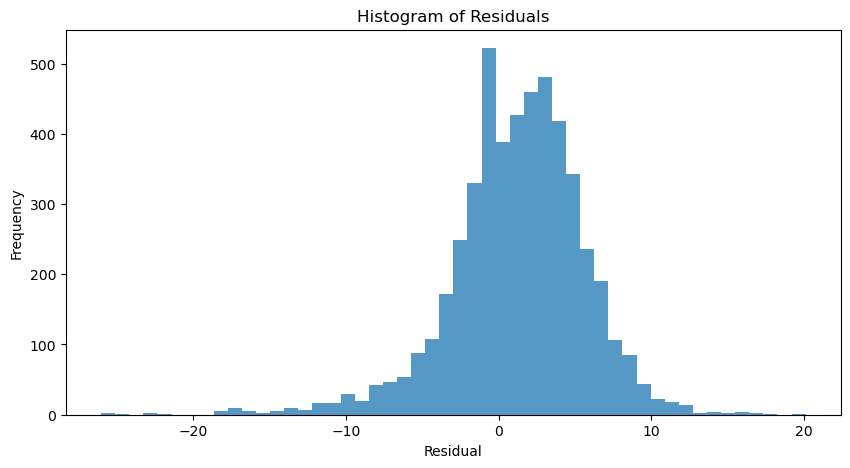

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import itertools
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# 假设你已经有一个数据对象 data
# data = ...

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 随机搜索超参数
num_samples = 50  # 选择搜索的参数组合数量
random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]

best_loss = float('inf')
best_params = None

for params in random_params:
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=params['hidden1'], 
        hidden2=params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

    losses = []
    for epoch in range(params['num_epochs']):
        loss = train(model, optimizer, data)
        losses.append(loss)

    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数重新训练模型
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index)
    residuals = data.y - pred

# 计算评估指标
y_true = data.y.detach().numpy()
y_pred = pred.detach().numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

# 可视化残差
plt.figure(figsize=(10, 5))
plt.hist(residuals.detach().numpy(), bins=50, alpha=0.75)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [8]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.model_selection import KFold
import numpy as np

# 定义划分子图的函数
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 定义K-Fold交叉验证
def k_fold_cross_validation(data, k=10, num_hops=2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    all_indices = np.arange(data.num_nodes)
    
    for train_idx, test_idx in kf.split(all_indices):
        (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
        
        # 重新初始化模型和优化器
        model = GATv2(
            in_channels=train_x.shape[1], 
            hidden1=best_params['hidden1'], 
            hidden2=best_params['hidden2'], 
            out_channels=train_y.shape[1], 
            dropout=best_params['dropout']
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
        
        # 训练模型
        model.train()
        for epoch in range(best_params['num_epochs']):
            optimizer.zero_grad()
            out = model(train_x, train_edge_index)
            loss = F.mse_loss(out, train_y)
            loss.backward()
            optimizer.step()
        
        # 测试模型
        model.eval()
        with torch.no_grad():
            pred = model(test_x, test_edge_index)
            y_true = test_y.numpy()
            y_pred = pred.numpy()
            
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
        
        results.append((mse, rmse, mae, r2))
    
    return results

# 假设你已经有一个数据对象 data
# data = ...

# 使用最佳超参数进行K-Fold交叉验证
results = k_fold_cross_validation(data)

# 打印K-Fold结果
for fold, (mse, rmse, mae, r2) in enumerate(results):
    print(f'Fold {fold + 1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

# 计算平均结果
avg_results = np.mean(results, axis=0)
print(f'Average - MSE: {avg_results[0]:.4f}, RMSE: {avg_results[1]:.4f}, MAE: {avg_results[2]:.4f}, R²: {avg_results[3]:.4f}')


Fold 1 - MSE: 19.5913, RMSE: 4.4262, MAE: 3.3560, R²: 0.7657
Fold 2 - MSE: 16.9188, RMSE: 4.1132, MAE: 3.0370, R²: 0.7950
Fold 3 - MSE: 21.9015, RMSE: 4.6799, MAE: 3.5602, R²: 0.7410
Fold 4 - MSE: 20.5636, RMSE: 4.5347, MAE: 3.4867, R²: 0.7531
Fold 5 - MSE: 17.9405, RMSE: 4.2356, MAE: 3.1753, R²: 0.7884
Fold 6 - MSE: 23.4385, RMSE: 4.8413, MAE: 3.7274, R²: 0.7219
Fold 7 - MSE: 21.0601, RMSE: 4.5891, MAE: 3.5356, R²: 0.7443
Fold 8 - MSE: 13.7979, RMSE: 3.7146, MAE: 2.6842, R²: 0.8331
Fold 9 - MSE: 17.4007, RMSE: 4.1714, MAE: 3.1536, R²: 0.7908
Fold 10 - MSE: 16.8741, RMSE: 4.1078, MAE: 3.0570, R²: 0.7966
Average - MSE: 18.9487, RMSE: 4.3414, MAE: 3.2773, R²: 0.7730


In [14]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import itertools
import random

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.y).item()
    return loss

# 定义早停机制
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# 定义划分子图的函数
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 超参数搜索函数
def hyperparameter_search(data, param_space, k=5, num_hops=1, num_samples=20):
    best_loss = float('inf')
    best_params = None
    random_params = [dict(zip(param_space, v)) for v in random.sample(list(itertools.product(*param_space.values())), num_samples)]
    
    for param_idx, params in enumerate(random_params):
        print(f'Starting hyperparameter set {param_idx + 1}/{num_samples}: {params}')
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_losses = []
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(np.arange(data.num_nodes))):
            print(f'Starting fold {fold + 1}/{k} for hyperparameter set {param_idx + 1}/{num_samples}')
            (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
            
            # 重新初始化模型和优化器
            model = GATv2(
                in_channels=train_x.shape[1], 
                hidden1=params['hidden1'], 
                hidden2=params['hidden2'], 
                out_channels=train_y.shape[1], 
                dropout=params['dropout']
            )
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
            early_stopping = EarlyStopping(patience=10)
            
            # 训练模型
            for epoch in range(params['num_epochs']):
                loss = train(model, optimizer, data)
                val_loss = evaluate(model, data)
                scheduler.step(val_loss)
                
                if (epoch + 1) % 10 == 0:
                    print(f'Hyperparameter set {param_idx + 1}/{num_samples}, Fold {fold + 1}/{k}, Epoch {epoch + 1}/{params["num_epochs"]}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
                
                if early_stopping.step(val_loss):
                    print(f'Early stopping at epoch {epoch + 1}')
                    break
            
            # 测试模型
            model.eval()
            with torch.no_grad():
                pred = model(test_x, test_edge_index)
                fold_loss = F.mse_loss(pred, test_y).item()
                fold_losses.append(fold_loss)
        
        avg_fold_loss = np.mean(fold_losses)
        print(f'Average loss for hyperparameter set {param_idx + 1}/{num_samples}: {avg_fold_loss:.4f}')
        if avg_fold_loss < best_loss:
            best_loss = avg_fold_loss
            best_params = params
    
    return best_params, best_loss

# 定义K-Fold交叉验证
def k_fold_cross_validation(data, best_params, k=5, num_hops=1):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    all_indices = np.arange(data.num_nodes)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(all_indices)):
        print(f'Starting fold {fold + 1}/{k}')
        (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
        
        # 重新初始化模型和优化器
        model = GATv2(
            in_channels=train_x.shape[1], 
            hidden1=best_params['hidden1'], 
            hidden2=best_params['hidden2'], 
            out_channels=train_y.shape[1], 
            dropout=best_params['dropout']
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10)
        
        # 训练模型
        model.train()
        for epoch in range(best_params['num_epochs']):
            loss = train(model, optimizer, data)
            val_loss = evaluate(model, data)
            scheduler.step(val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f'Fold {fold + 1}/{k}, Epoch {epoch + 1}/{best_params["num_epochs"]}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
            
            if early_stopping.step(val_loss):
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
        # 测试模型
        model.eval()
        with torch.no_grad():
            pred = model(test_x, test_edge_index)
            y_true = test_y.numpy()
            y_pred = pred.numpy()
            
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
        
        print(f'Fold {fold + 1} results - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
        results.append((mse, rmse, mae, r2))
    
    return results

# 假设你已经有一个数据对象 data
# data = ...

# 定义超参数空间
param_space = {
    'lr': [0.001, 0.005, 0.01],
    'weight_decay': [5e-4, 1e-3, 5e-3],
    'hidden1': [32, 64, 128],
    'hidden2': [16, 32, 64],
    'dropout': [0.3, 0.5, 0.7],
    'num_epochs': [200]
}

# 使用K-Fold交叉验证进行超参数搜索
best_params, best_loss = hyperparameter_search(data, param_space)
print(f'Best params: {best_params}, Best loss: {best_loss:.4f}')

# 使用最佳超参数进行K-Fold交叉验证
results = k_fold_cross_validation(data, best_params)

# 打印K-Fold结果
for fold, (mse, rmse, mae, r2) in enumerate(results):
    print(f'Fold {fold + 1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

# 计算平均结果
avg_results = np.mean(results, axis=0)
print(f'Average - MSE: {avg_results[0]:.4f}, RMSE: {avg_results[1]:.4f}, MAE: {avg_results[2]:.4f}, R²: {avg_results[3]:.4f}')


Starting hyperparameter set 1/20: {'lr': 0.005, 'weight_decay': 0.005, 'hidden1': 32, 'hidden2': 64, 'dropout': 0.7, 'num_epochs': 200}
Starting fold 1/5 for hyperparameter set 1/20
Hyperparameter set 1/20, Fold 1/5, Epoch 10/200, Loss: 254.7401, Val Loss: 242.0734
Hyperparameter set 1/20, Fold 1/5, Epoch 20/200, Loss: 198.6641, Val Loss: 165.9631
Hyperparameter set 1/20, Fold 1/5, Epoch 30/200, Loss: 145.0933, Val Loss: 117.1710
Hyperparameter set 1/20, Fold 1/5, Epoch 40/200, Loss: 103.9970, Val Loss: 86.0367
Hyperparameter set 1/20, Fold 1/5, Epoch 50/200, Loss: 77.2997, Val Loss: 64.1659
Hyperparameter set 1/20, Fold 1/5, Epoch 60/200, Loss: 60.4422, Val Loss: 50.3068
Hyperparameter set 1/20, Fold 1/5, Epoch 70/200, Loss: 52.0132, Val Loss: 42.3075
Hyperparameter set 1/20, Fold 1/5, Epoch 80/200, Loss: 48.0542, Val Loss: 38.2732
Hyperparameter set 1/20, Fold 1/5, Epoch 90/200, Loss: 47.1615, Val Loss: 34.7121
Hyperparameter set 1/20, Fold 1/5, Epoch 100/200, Loss: 47.4443, Val Loss

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 2/5, Epoch 10/200, Loss: 292.3027, Val Loss: 283.0978
Fold 2/5, Epoch 20/200, Loss: 278.8185, Val Loss: 270.5072
Fold 2/5, Epoch 30/200, Loss: 265.0751, Val Loss: 258.1043
Fold 2/5, Epoch 40/200, Loss: 249.0732, Val Loss: 242.3828
Fold 2/5, Epoch 50/200, Loss: 229.7049, Val Loss: 219.7743
Fold 2/5, Epoch 60/200, Loss: 207.0096, Val Loss: 200.6729
Fold 2/5, Epoch 70/200, Loss: 179.9657, Val Loss: 170.8259
Fold 2/5, Epoch 80/200, Loss: 150.6038, Val Loss: 142.1605
Fold 2/5, Epoch 90/200, Loss: 123.6855, Val Loss: 117.0004
Fold 2/5, Epoch 100/200, Loss: 97.6988, Val Loss: 93.8256
Fold 2/5, Epoch 110/200, Loss: 74.9499, Val Loss: 74.9527
Fold 2/5, Epoch 120/200, Loss: 55.4012, Val Loss: 47.0092
Fold 2/5, Epoch 130/200, Loss: 41.2080, Val Loss: 37.9980
Fold 2/5, Epoch 140/200, Loss: 33.6205, Val Loss: 26.1046
Fold 2/5, Epoch 150/200, Loss: 28.5020, Val Loss: 19.8438
Fold 2/5, Epoch 160/200, Loss: 26.2810, Val Loss: 18.0056
Fold 2/5, Epoch 170/200, Loss: 25.0902, Val Loss: 14.8816
Fold 

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 3/5, Epoch 10/200, Loss: 292.2411, Val Loss: 279.2829
Fold 3/5, Epoch 20/200, Loss: 279.9930, Val Loss: 267.9483
Fold 3/5, Epoch 30/200, Loss: 266.6738, Val Loss: 257.3313
Fold 3/5, Epoch 40/200, Loss: 249.7980, Val Loss: 243.6298
Fold 3/5, Epoch 50/200, Loss: 229.4246, Val Loss: 228.7450
Fold 3/5, Epoch 60/200, Loss: 203.4391, Val Loss: 199.3084
Fold 3/5, Epoch 70/200, Loss: 166.8697, Val Loss: 163.0677
Fold 3/5, Epoch 80/200, Loss: 130.4275, Val Loss: 88.5377
Fold 3/5, Epoch 90/200, Loss: 100.8291, Val Loss: 79.5236
Fold 3/5, Epoch 100/200, Loss: 78.2353, Val Loss: 66.8182
Fold 3/5, Epoch 110/200, Loss: 61.5978, Val Loss: 55.5081
Fold 3/5, Epoch 120/200, Loss: 50.9493, Val Loss: 46.7470
Fold 3/5, Epoch 130/200, Loss: 43.0047, Val Loss: 36.7039
Fold 3/5, Epoch 140/200, Loss: 37.6771, Val Loss: 31.5918
Fold 3/5, Epoch 150/200, Loss: 34.3741, Val Loss: 26.5834
Fold 3/5, Epoch 160/200, Loss: 31.8091, Val Loss: 25.7827
Fold 3/5, Epoch 170/200, Loss: 29.2777, Val Loss: 21.1632
Fold 3/

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 4/5, Epoch 10/200, Loss: 277.5693, Val Loss: 261.2489
Fold 4/5, Epoch 20/200, Loss: 256.2936, Val Loss: 238.1939
Fold 4/5, Epoch 30/200, Loss: 234.2374, Val Loss: 216.2613
Fold 4/5, Epoch 40/200, Loss: 209.9187, Val Loss: 196.8961
Fold 4/5, Epoch 50/200, Loss: 185.5898, Val Loss: 173.1185
Fold 4/5, Epoch 60/200, Loss: 160.4519, Val Loss: 147.8843
Fold 4/5, Epoch 70/200, Loss: 134.1865, Val Loss: 125.3577
Fold 4/5, Epoch 80/200, Loss: 110.7484, Val Loss: 100.6690
Fold 4/5, Epoch 90/200, Loss: 88.6502, Val Loss: 86.2985
Fold 4/5, Epoch 100/200, Loss: 71.2088, Val Loss: 67.4350
Fold 4/5, Epoch 110/200, Loss: 57.9692, Val Loss: 55.6640
Fold 4/5, Epoch 120/200, Loss: 47.2208, Val Loss: 45.3324
Fold 4/5, Epoch 130/200, Loss: 40.9010, Val Loss: 35.0866
Fold 4/5, Epoch 140/200, Loss: 35.2851, Val Loss: 28.1915
Fold 4/5, Epoch 150/200, Loss: 31.8766, Val Loss: 22.9648
Fold 4/5, Epoch 160/200, Loss: 29.7445, Val Loss: 20.9964
Fold 4/5, Epoch 170/200, Loss: 28.8508, Val Loss: 17.7882
Fold 4/

C:\Users\0\anaconda3\envs\envGEOG0051\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 5/5, Epoch 10/200, Loss: 293.7069, Val Loss: 284.4280
Fold 5/5, Epoch 20/200, Loss: 275.1158, Val Loss: 260.7281
Fold 5/5, Epoch 30/200, Loss: 255.0827, Val Loss: 240.1665
Fold 5/5, Epoch 40/200, Loss: 232.8780, Val Loss: 218.6119
Fold 5/5, Epoch 50/200, Loss: 208.0149, Val Loss: 196.3595
Fold 5/5, Epoch 60/200, Loss: 183.0681, Val Loss: 177.9437
Fold 5/5, Epoch 70/200, Loss: 155.7558, Val Loss: 140.8211
Fold 5/5, Epoch 80/200, Loss: 129.2491, Val Loss: 119.5397
Fold 5/5, Epoch 90/200, Loss: 104.7513, Val Loss: 94.6224
Fold 5/5, Epoch 100/200, Loss: 84.5097, Val Loss: 71.8301
Fold 5/5, Epoch 110/200, Loss: 65.0582, Val Loss: 55.7219
Fold 5/5, Epoch 120/200, Loss: 52.4204, Val Loss: 42.6659
Fold 5/5, Epoch 130/200, Loss: 41.6131, Val Loss: 33.3600
Fold 5/5, Epoch 140/200, Loss: 35.7423, Val Loss: 28.9625
Fold 5/5, Epoch 150/200, Loss: 32.0644, Val Loss: 23.7786
Fold 5/5, Epoch 160/200, Loss: 28.9811, Val Loss: 20.4176
Fold 5/5, Epoch 170/200, Loss: 26.8033, Val Loss: 18.1330
Fold 5

In [15]:
best_params

{'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 16,
 'dropout': 0.3,
 'num_epochs': 200}

Epoch 10/200, Loss: 278.7574
Epoch 20/200, Loss: 260.9619
Epoch 30/200, Loss: 241.9413
Epoch 40/200, Loss: 221.8063
Epoch 50/200, Loss: 199.8777
Epoch 60/200, Loss: 176.3518
Epoch 70/200, Loss: 151.4025
Epoch 80/200, Loss: 129.8307
Epoch 90/200, Loss: 107.3513
Epoch 100/200, Loss: 88.3701
Epoch 110/200, Loss: 68.7163
Epoch 120/200, Loss: 53.8451
Epoch 130/200, Loss: 42.7732
Epoch 140/200, Loss: 35.6629
Epoch 150/200, Loss: 30.4989
Epoch 160/200, Loss: 27.4056
Epoch 170/200, Loss: 26.3654
Epoch 180/200, Loss: 25.0207
Epoch 190/200, Loss: 23.1915
Epoch 200/200, Loss: 23.8048
Test results - MSE: 19.1312, RMSE: 4.3739, MAE: 3.0762, R²: 0.7507


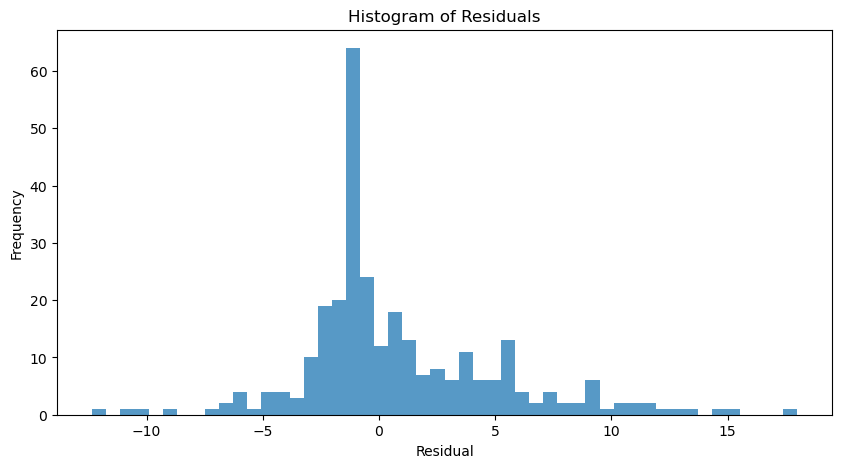

In [68]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.y).item()
    return loss

# 定义早停机制
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# 定义创建子图的函数，包括边界节点
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 使用最佳参数重新训练模型并评估
def evaluate_leave_one_out(data, best_params, region_mask, num_hops=2):
    # 提取特定区域节点
    test_idx = torch.where(region_mask)[0].numpy()
    train_idx = np.setdiff1d(np.arange(data.num_nodes), test_idx)
    
    # 创建训练和测试子图
    (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
    
    # 初始化模型和优化器
    model = GATv2(
        in_channels=train_x.shape[1], 
        hidden1=best_params['hidden1'], 
        hidden2=best_params['hidden2'], 
        out_channels=train_y.shape[1], 
        dropout=best_params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
    # 训练模型
    model.train()
    for epoch in range(best_params['num_epochs']):
        loss = train(model, optimizer, data)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{best_params["num_epochs"]}, Loss: {loss:.4f}')
    
    # 测试模型
    model.eval()
    with torch.no_grad():
        pred = model(test_x, test_edge_index)
        y_true = test_y.numpy()
        y_pred = pred.numpy()
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
    
    print(f'Test results - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
    
    # 绘制残差图
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, alpha=0.75)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()
    
    return mse, rmse, mae, r2

# 假设你已经有一个数据对象 data 和最佳参数 best_params
# data = ...
# best_params = ...

# 加载或创建GeoDataFrame gdf，这里假设gdf包含了每个节点的地理信息
# gdf = ...

# 假设LSOA21NM是GeoDataFrame中表示区域名称的列，并且我们要提取Southwark区域
region_name = 'Tower Hamlets'
region_mask = gdf['LSOA21NM'].str.contains(region_name)

# 将GeoDataFrame中的索引与图中的节点索引对齐，创建region_mask
region_mask = torch.tensor(region_mask.values, dtype=torch.bool, device=data.edge_index.device)

# 使用最佳参数重新训练模型并在特定区域上测试
mse, rmse, mae, r2 = evaluate_leave_one_out(data, best_params, region_mask)

Epoch 10/200, Loss: 307.6649
Epoch 20/200, Loss: 293.7681
Epoch 30/200, Loss: 279.8307
Epoch 40/200, Loss: 265.4702
Epoch 50/200, Loss: 247.7393
Epoch 60/200, Loss: 225.9639
Epoch 70/200, Loss: 198.8463
Epoch 80/200, Loss: 170.1722
Epoch 90/200, Loss: 141.7085
Epoch 100/200, Loss: 114.8147
Epoch 110/200, Loss: 93.5004
Epoch 120/200, Loss: 75.8959
Epoch 130/200, Loss: 61.1520
Epoch 140/200, Loss: 51.3650
Epoch 150/200, Loss: 44.9500
Epoch 160/200, Loss: 38.5984
Epoch 170/200, Loss: 33.6519
Epoch 180/200, Loss: 31.1899
Epoch 190/200, Loss: 29.3791
Epoch 200/200, Loss: 28.0969
Test results - MSE: 13.0527, RMSE: 3.6129, MAE: 2.4549, R²: 0.7974


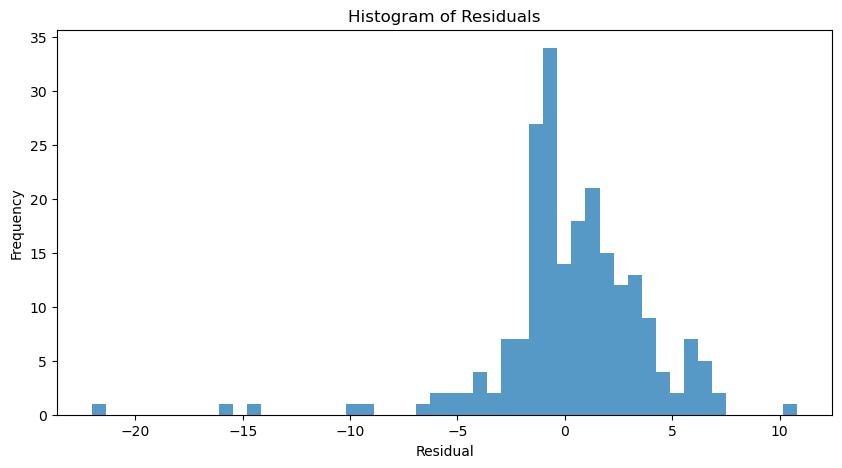

In [22]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.y).item()
    return loss

# 定义早停机制
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# 定义创建子图的函数，包括边界节点
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 使用最佳参数重新训练模型并评估
def evaluate_leave_one_out(data, best_params, region_mask, num_hops=2):
    # 提取特定区域节点
    test_idx = torch.where(region_mask)[0].numpy()
    train_idx = np.setdiff1d(np.arange(data.num_nodes), test_idx)
    
    # 创建训练和测试子图
    (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
    
    # 初始化模型和优化器
    model = GATv2(
        in_channels=train_x.shape[1], 
        hidden1=best_params['hidden1'], 
        hidden2=best_params['hidden2'], 
        out_channels=train_y.shape[1], 
        dropout=best_params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
    # 训练模型
    model.train()
    for epoch in range(best_params['num_epochs']):
        loss = train(model, optimizer, data)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{best_params["num_epochs"]}, Loss: {loss:.4f}')
    
    # 测试模型
    model.eval()
    with torch.no_grad():
        pred = model(test_x, test_edge_index)
        y_true = test_y.numpy()
        y_pred = pred.numpy()
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
    
    print(f'Test results - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
    
    # 绘制残差图
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, alpha=0.75)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()
    
    return mse, rmse, mae, r2

# 假设你已经有一个数据对象 data 和最佳参数 best_params
# data = ...
# best_params = ...

# 加载或创建GeoDataFrame gdf，这里假设gdf包含了每个节点的地理信息
# gdf = ...

# 假设LSOA21NM是GeoDataFrame中表示区域名称的列，并且我们要提取Southwark区域
region_name = 'Barking'
region_mask = gdf['LSOA21NM'].str.contains(region_name)

# 将GeoDataFrame中的索引与图中的节点索引对齐，创建region_mask
region_mask = torch.tensor(region_mask.values, dtype=torch.bool, device=data.edge_index.device)

# 使用最佳参数重新训练模型并在特定区域上测试
mse, rmse, mae, r2 = evaluate_leave_one_out(data, best_params, region_mask)

Epoch 10/200, Loss: 315.3469
Epoch 20/200, Loss: 302.9278
Epoch 30/200, Loss: 289.6350
Epoch 40/200, Loss: 274.5185
Epoch 50/200, Loss: 255.3232
Epoch 60/200, Loss: 231.4521
Epoch 70/200, Loss: 201.6472
Epoch 80/200, Loss: 168.8994
Epoch 90/200, Loss: 138.4571
Epoch 100/200, Loss: 111.9540
Epoch 110/200, Loss: 88.6902
Epoch 120/200, Loss: 70.7441
Epoch 130/200, Loss: 57.7585
Epoch 140/200, Loss: 48.1090
Epoch 150/200, Loss: 41.5384
Epoch 160/200, Loss: 36.9403
Epoch 170/200, Loss: 33.8970
Epoch 180/200, Loss: 30.3686
Epoch 190/200, Loss: 27.6558
Epoch 200/200, Loss: 25.6336
Test results - MSE: 15.1154, RMSE: 3.8879, MAE: 3.0231, R²: 0.7296


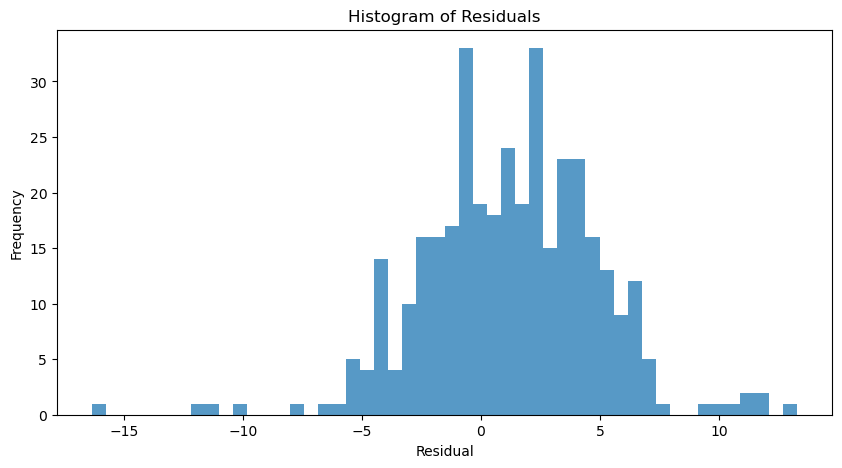

In [66]:
import torch
from torch_geometric.utils import k_hop_subgraph
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.fc1(x)
        return x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, data.y).item()
    return loss

# 定义早停机制
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

# 定义创建子图的函数，包括边界节点
def create_subgraph(data, train_idx, test_idx, num_hops):
    train_idx = torch.tensor(train_idx, dtype=torch.long, device=data.edge_index.device)
    test_idx = torch.tensor(test_idx, dtype=torch.long, device=data.edge_index.device)
    
    # 获取训练集子图，包含 train_idx 节点以及 num_hops 范围内的邻居
    train_subgraph = k_hop_subgraph(train_idx, num_hops, data.edge_index, relabel_nodes=True)
    train_edge_index, train_x, train_y = train_subgraph[1], data.x[train_subgraph[0]], data.y[train_subgraph[0]]
    
    # 获取测试集子图，包含 test_idx 节点以及 num_hops 范围内的邻居
    test_subgraph = k_hop_subgraph(test_idx, num_hops, data.edge_index, relabel_nodes=True)
    test_edge_index, test_x, test_y = test_subgraph[1], data.x[test_subgraph[0]], data.y[test_subgraph[0]]
    
    return (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y)

# 使用最佳参数重新训练模型并评估
def evaluate_leave_one_out(data, best_params, region_mask, num_hops=2):
    # 提取特定区域节点
    test_idx = torch.where(region_mask)[0].numpy()
    train_idx = np.setdiff1d(np.arange(data.num_nodes), test_idx)
    
    # 创建训练和测试子图
    (train_x, train_edge_index, train_y), (test_x, test_edge_index, test_y) = create_subgraph(data, train_idx, test_idx, num_hops)
    
    # 初始化模型和优化器
    model = GATv2(
        in_channels=train_x.shape[1], 
        hidden1=best_params['hidden1'], 
        hidden2=best_params['hidden2'], 
        out_channels=train_y.shape[1], 
        dropout=best_params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
    # 训练模型
    model.train()
    for epoch in range(best_params['num_epochs']):
        loss = train(model, optimizer, data)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{best_params["num_epochs"]}, Loss: {loss:.4f}')
    
    # 测试模型
    model.eval()
    with torch.no_grad():
        pred = model(test_x, test_edge_index)
        y_true = test_y.numpy()
        y_pred = pred.numpy()
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
    
    print(f'Test results - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
    
    # 绘制残差图
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, alpha=0.75)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.show()
    
    return mse, rmse, mae, r2

# 假设你已经有一个数据对象 data 和最佳参数 best_params
# data = ...
# best_params = ...

# 加载或创建GeoDataFrame gdf，这里假设gdf包含了每个节点的地理信息
# gdf = ...

# 假设LSOA21NM是GeoDataFrame中表示区域名称的列，并且我们要提取Southwark区域
region_name = 'Barnet'
region_mask = gdf['LSOA21NM'].str.contains(region_name)

# 将GeoDataFrame中的索引与图中的节点索引对齐，创建region_mask
region_mask = torch.tensor(region_mask.values, dtype=torch.bool, device=data.edge_index.device)

# 使用最佳参数重新训练模型并在特定区域上测试
mse, rmse, mae, r2 = evaluate_leave_one_out(data, best_params, region_mask)

In [24]:
model

GATv2(
  (conv1): GATv2Conv(47, 64, heads=1)
  (conv2): GATv2Conv(64, 32, heads=1)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

In [4]:
best_params = {'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 16,
 'dropout': 0.3,
 'num_epochs': 200}

Epoch 10/200, Loss: 287.0813
Epoch 20/200, Loss: 271.6575
Epoch 30/200, Loss: 254.6274
Epoch 40/200, Loss: 234.6653
Epoch 50/200, Loss: 214.5206
Epoch 60/200, Loss: 191.0385
Epoch 70/200, Loss: 163.9301
Epoch 80/200, Loss: 137.7475
Epoch 90/200, Loss: 112.7459
Epoch 100/200, Loss: 89.6400
Epoch 110/200, Loss: 70.5754
Epoch 120/200, Loss: 55.4426
Epoch 130/200, Loss: 44.5241
Epoch 140/200, Loss: 35.6496
Epoch 150/200, Loss: 31.5799
Epoch 160/200, Loss: 28.0929
Epoch 170/200, Loss: 27.1626
Epoch 180/200, Loss: 24.1964
Epoch 190/200, Loss: 24.3830
Epoch 200/200, Loss: 23.2071
Shape of conv1 embeddings: (4994, 128)
Shape of conv2 embeddings: (4994, 16)
Explained Variance Ratio: [0.7594014]
PCA1 Top Contributors:
12    0.060304
7     0.058969
9     0.058885
5     0.057505
2     0.057180
14    0.053818
0     0.050761
1     0.049755
10    0.048762
13    0.048327
Name: PCA1, dtype: float32


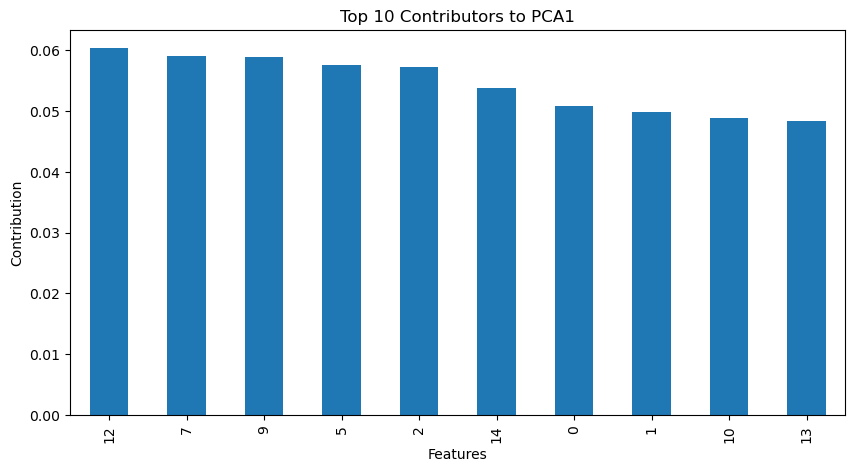

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def train_with_best_params(data, best_params, num_epochs=200):
    model = GATv2(
        in_channels=data.x.shape[1], 
        hidden1=best_params['hidden1'], 
        hidden2=best_params['hidden2'], 
        out_channels=data.y.shape[1], 
        dropout=best_params['dropout']
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
    losses = []
    for epoch in range(num_epochs):
        loss = train(model, optimizer, data)
        losses.append(loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}')
    return model, losses

# 使用最佳参数训练模型
# 假设你已经有一个数据对象 data 和最佳参数 best_params
# best_params = {'lr': 0.005, 'weight_decay': 0.001, 'hidden1': 64, 'hidden2': 32, 'dropout': 0.5}
model, losses = train_with_best_params(data, best_params)

# 提取嵌入
model.eval()
with torch.no_grad():
    conv1_out, conv2_out, _ = model(data.x, data.edge_index)
    conv1_embeddings = conv1_out.cpu().numpy()
    conv2_embeddings = conv2_out.cpu().numpy()

# 确保嵌入已定义
print(f"Shape of conv1 embeddings: {conv1_embeddings.shape}")
print(f"Shape of conv2 embeddings: {conv2_embeddings.shape}")

# 确保 n_components 设置正确
pca_components = 1
if min(conv2_embeddings.shape) < pca_components:
    pca_components = min(conv2_embeddings.shape)

# 计算PCA并获取解释方差比
pca = PCA(n_components=pca_components, random_state=0)
pca_result = pca.fit_transform(conv2_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

# 计算载荷
loadings = pca.components_.T

# 计算特征贡献度（解释方差比乘以载荷的平方）
contributions = loadings ** 2 * explained_variance_ratio

# 创建贡献度矩阵DataFrame
contribution_matrix = pd.DataFrame(contributions, columns=[f'PCA{i+1}' for i in range(pca_components)])

# 打印每个主成分的前几个变量及其贡献
print("PCA1 Top Contributors:")
print(contribution_matrix['PCA1'].sort_values(ascending=False).head(10))

if pca_components > 1:
    print("\nPCA2 Top Contributors:")
    print(contribution_matrix['PCA2'].sort_values(ascending=False).head(10))

# 可视化每个主成分的前几个变量及其贡献
plt.figure(figsize=(10, 5))
contribution_matrix['PCA1'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Contributors to PCA1')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.show()

if pca_components > 1:
    plt.figure(figsize=(10, 5))
    contribution_matrix['PCA2'].sort_values(ascending=False).head(10).plot(kind='bar')
    plt.title('Top 10 Contributors to PCA2')
    plt.xlabel('Features')
    plt.ylabel('Contribution')
    plt.show()

In [6]:
def plot_variable_v2(gdf, variable, variable_name):

    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        # 'color':'#808080',
        # 'edgecolor': 'black',
        # 'hatch': '///',  # this is optional, if you'd like a hatch pattern for missing data
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame
    ax = gdf.plot(column=variable, legend=True, figsize=(15, 10), cmap=colormap, missing_kwds=missing_data_color)

    # Remove the axes
    plt.axis('off')

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=33)

    # Title
    plt.title(variable_name, fontsize=44)

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\0\\anaconda3\\envs\\envGEOG0051\\Lib\\site-packages\\matplotlib\\pyplot.py'>

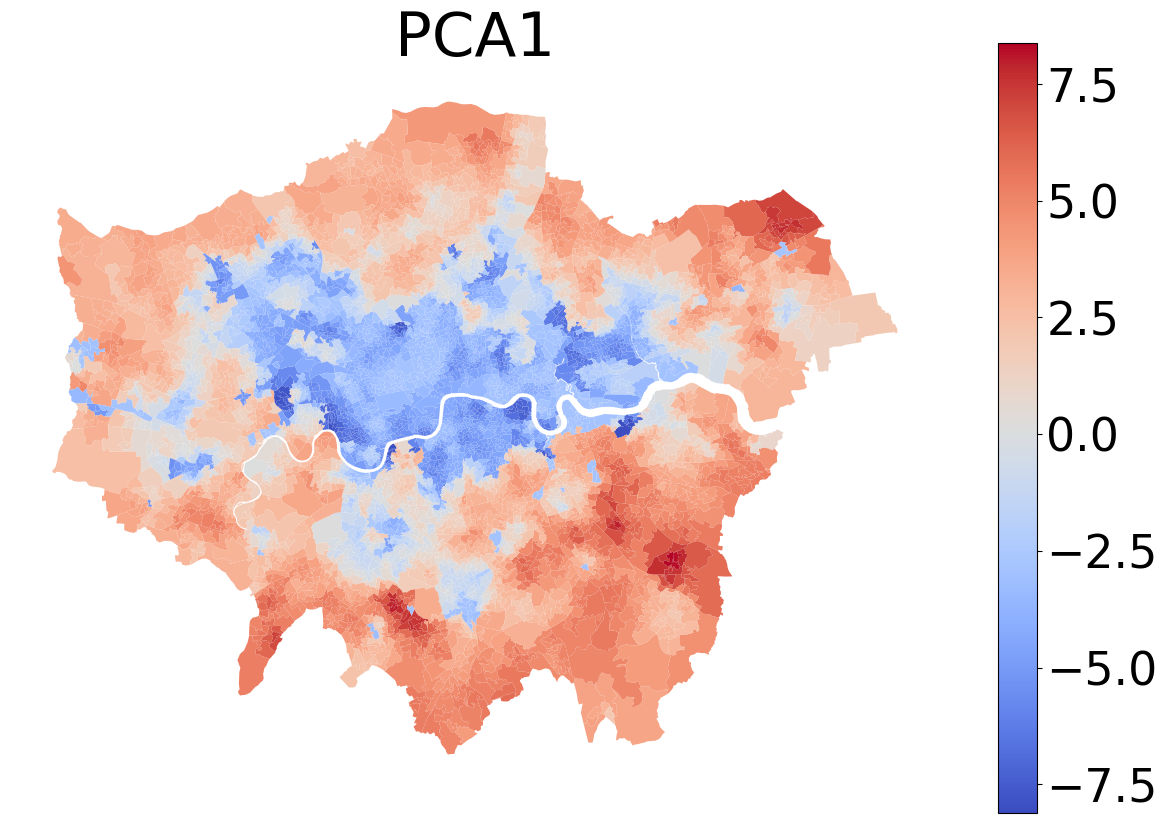

In [7]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the CSV file
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# Convert the 'geometry' column to Shapely geometry objects
df['geometry'] = df['geometry'].apply(wkt.loads)

# Create the GeoDataFrame
gdf_plot = gpd.GeoDataFrame(df, geometry='geometry')

# 将PCA结果添加到GeoDataFrame中
gdf_plot['PCA1'] = pca_result[:, 0]
# gdf_plot['PCA2'] = pca_result[:, 1]
# gdf_plot['PCA3'] = pca_result[:, 2]

# 可视化PCA1和PCA2
plot_variable_v2(gdf_plot, 'PCA1', 'PCA1')
# plot_variable_v2(gdf_plot, 'PCA2', 'PCA2')
# plot_variable_v2(gdf_plot, 'PCA3', 'PCA3')

Correlation with PCA components:
                                                        PCA1
c_percent Aged 10 to 14 years                       0.338076
c_percent Aged 15 to 19 years                       0.060655
c_percent Aged 20 to 24 years                      -0.473655
c_percent Aged 25 to 29 years                      -0.587729
c_percent Aged 30 to 34 years                      -0.520968
c_percent Aged 35 to 39 years                      -0.269274
c_percent Aged 40 to 44 years                       0.136102
c_percent Aged 65 to 69 years                       0.415400
c_percent Aged 70 to 74 years                       0.479661
c_percent Aged 75 to 79 years                       0.452555
c_percent Aged 80 to 84 years                       0.419365
c_percent Aged 85 years and over                    0.403481
c_percent mixed                                    -0.205567
c_percent white                                     0.367980
c_percent 2. Professional occupations              -

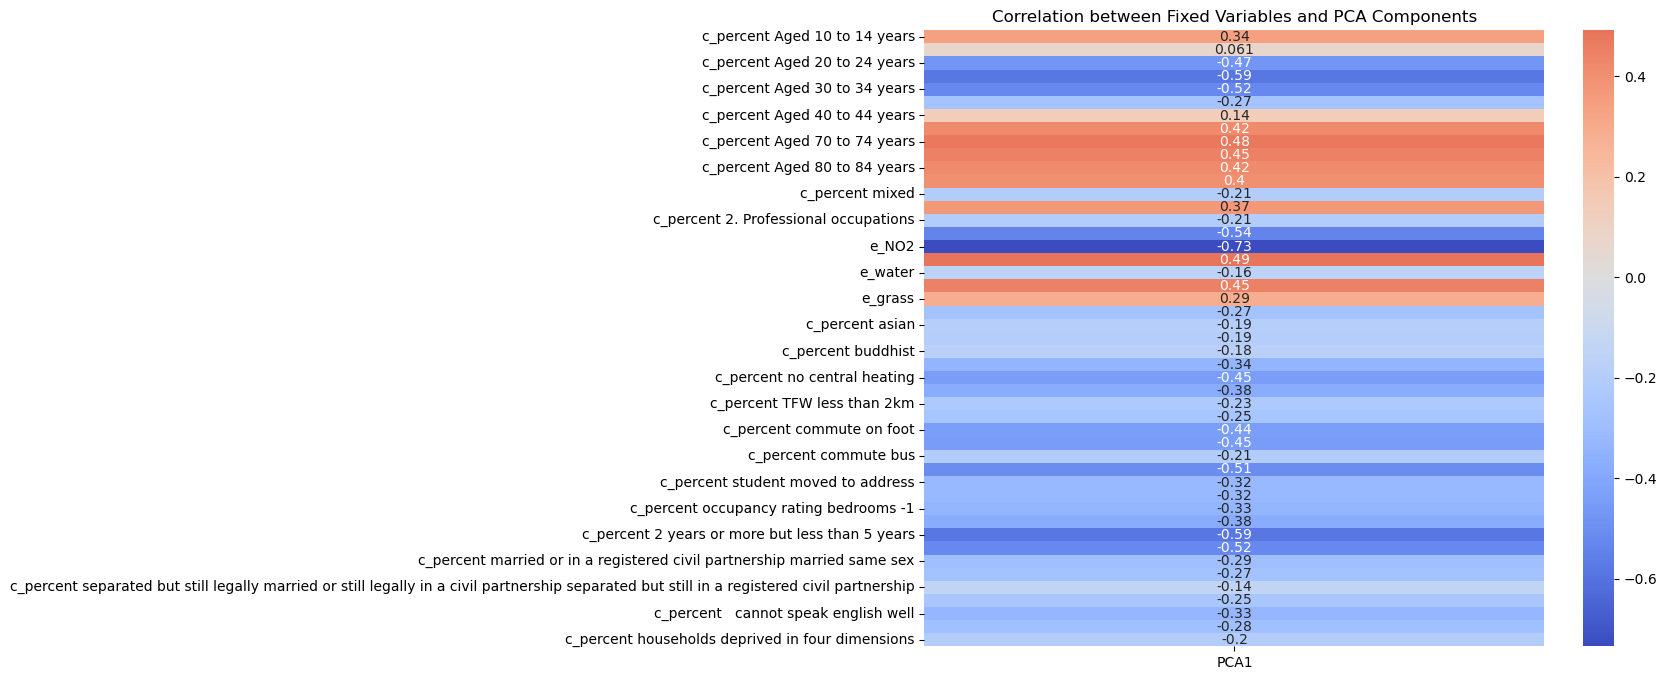

In [63]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# 提取PCA主成分
pca_df = pd.DataFrame(pca_result, columns=[f'PCA{i+1}' for i in range(pca_components)])

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)
# 固定选取的变量
fixed_columns = [
    'c_percent Aged 10 to 14 years',
    'c_percent Aged 15 to 19 years',
    'c_percent Aged 20 to 24 years',
    'c_percent Aged 25 to 29 years',
    'c_percent Aged 30 to 34 years',
    'c_percent Aged 35 to 39 years',
    'c_percent Aged 40 to 44 years',
    'c_percent Aged 65 to 69 years',
    'c_percent Aged 70 to 74 years',
    'c_percent Aged 75 to 79 years',
    'c_percent Aged 80 to 84 years',
    'c_percent Aged 85 years and over',
    'c_percent mixed',
    'c_percent white',
    'c_percent 2. Professional occupations',
    'c_pop_density',
    'e_NO2',
    'e_ndvi',
    'e_water',
    'e_trees',
    'e_grass',
    'e_bare',
    'c_percent asian',
    'c_percent black',
    'c_percent buddhist',
    'c_percent muslim',
    'c_percent no central heating',
    'c_percent communal heating',
    'c_percent TFW less than 2km',
    'c_percent 49 or more hours worked',
    'c_percent commute on foot',
    'c_percent commute metro rail',
    'c_percent commute bus',
    'c_percent commute bicycle',
    'c_percent student moved to address',
    'c_percent occupancy rating bedrooms -2',
    'c_percent occupancy rating bedrooms -1',
    # 'c_percent occupancy rating rooms -1',
    'c_percent 10 years or more',
    'c_percent 2 years or more but less than 5 years',
    'c_percent 5 years or more but less than 10 years',
    'c_percent married or in a registered civil partnership married same sex',
    'c_percent married or in a registered civil partnership in a registered civil partnership',
    # 'c_percent married or in a registered civil partnership in a registered civil partnership same sex',
    'c_percent separated but still legally married or still legally in a civil partnership separated but still in a registered civil partnership',
    'c_percent divorced or civil partnership dissolved formerly in a civil partnership now legally dissolved',
    'c_percent   cannot speak english well',
    'c_percent   cannot speak english',
    'c_percent households deprived in four dimensions'
]
# 提取固定变量
fixed_features = gdf[fixed_columns].apply(pd.to_numeric, errors='coerce')

# 标准化固定变量
scaler = StandardScaler()
fixed_features_scaled = scaler.fit_transform(fixed_features)
fixed_features_df = pd.DataFrame(fixed_features_scaled, columns=fixed_columns)

# 计算PCA主成分与固定变量的相关性
correlation_matrix = fixed_features_df.join(pca_df).corr()
pca_corr = correlation_matrix.loc[fixed_columns, [f'PCA{i+1}' for i in range(pca_components)]]

# 打印相关性矩阵
print("Correlation with PCA components:")
print(pca_corr)

# 可视化相关性矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(pca_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Fixed Variables and PCA Components')
plt.show()

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Assuming 'data' is a pre-defined PyG data object
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
wrapped_model = WrappedModel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    _, _, pred = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    residuals = data.y - pred

from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
wrapped_model.eval()

WrappedModel(
  (model): GATv2(
    (conv1): GATv2Conv(47, 128, heads=1)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GATv2Conv(128, 16, heads=1)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [51]:
for explanation_type in ['phenomenon', 'model']:
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 0
explanation = explainer(data.x, data.edge_index, index=node_idx)

# 输出解释结果
print(f'Generated explanations in {explanation.available_explanations}')

# 可视化特征重要性
path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

# 可视化子图
path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

# 获取子图节点索引
edge_mask = explanation.edge_mask > 0.5  # 使用掩码阈值
edge_index = data.edge_index[:, edge_mask]
node_indices = edge_index.unique().tolist()

print("Node indices in the subgraph:", node_indices)

ValueError: The 'target' has to be provided for the explanation type 'phenomenon'

In [25]:
explanation.node_mask

tensor([[0.6942, 0.1836, 0.1183,  ..., 0.8007, 0.1252, 0.8223],
        [0.5515, 0.1697, 0.1608,  ..., 0.4354, 0.1695, 0.7110],
        [0.1330, 0.1821, 0.1357,  ..., 0.1808, 0.1882, 0.1459],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [21]:
explanation.edge_mask

tensor([0.9072, 0.9165, 0.9089,  ..., 0.0000, 0.0000, 0.0000])

In [173]:
for explanation_type in ['phenomenon']:
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='object',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
        # threshold_config=dict(threshold_type='hard', value=0.5) 
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 31
explanation = explainer(data.x, data.edge_index, index=node_idx, target = data.y,)

# 输出解释结果
print(f'Generated explanations in {explanation.available_explanations}')

# 可视化特征重要性
# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# 可视化子图
path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

# 获取子图节点索引
edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
edge_index = data.edge_index[:, edge_mask]
node_indices = edge_index.unique().tolist()

print("Node indices in the subgraph:", node_indices)


Generated explanations in ['node_mask', 'edge_mask']
Subgraph visualization plot has been saved to 'subgraph.pdf'
Node indices in the subgraph: [10, 11, 12, 13, 14, 15, 28, 29, 30, 31, 32, 34, 55, 57, 58, 96, 97, 98, 99, 100, 2150, 2211, 2212]


In [176]:
explanation.node_mask[875]

tensor([0.])

In [175]:
# 获取每个节点对应的 node_mask 值
node_mask_values = [explanation.node_mask[idx].item() for idx in node_indices]

# 打印所有索引和对应的 node_mask 值
for idx, mask_value in zip(node_indices, node_mask_values):
    print(f"Node: {idx}, value: {mask_value}")

Node: 10, value: 0.8907425403594971
Node: 11, value: 0.4975908696651459
Node: 12, value: 0.3188534379005432
Node: 13, value: 0.29464852809906006
Node: 14, value: 0.18129922449588776
Node: 15, value: 0.24072885513305664
Node: 28, value: 0.8835070729255676
Node: 29, value: 0.8030089139938354
Node: 30, value: 0.1763285994529724
Node: 31, value: 0.5444632768630981
Node: 32, value: 0.7711808681488037
Node: 34, value: 0.7837707996368408
Node: 55, value: 0.15530365705490112
Node: 57, value: 0.869354248046875
Node: 58, value: 0.8998987674713135
Node: 96, value: 0.14097855985164642
Node: 97, value: 0.14343474805355072
Node: 98, value: 0.16573411226272583
Node: 99, value: 0.13703301548957825
Node: 100, value: 0.492918998003006
Node: 2150, value: 0.8095879554748535
Node: 2211, value: 0.8120524883270264
Node: 2212, value: 0.7725449800491333


In [141]:
A = explanation.get_explanation_subgraph()
A

Explanation(node_mask=[16, 1], edge_mask=[35], target=[16, 1], index=[1], x=[16, 47], edge_index=[2, 35])

In [122]:
A.edge_mask

tensor([0.9063, 0.1522, 0.2231, 0.0848, 0.1527, 0.9132, 0.1899, 0.8175, 0.2708,
        0.8695, 0.0928, 0.8833, 0.8992, 0.7238, 0.8285, 0.8332, 0.8871, 0.9085,
        0.9065, 0.6402, 0.1035, 0.1422, 0.8359, 0.7961, 0.7678, 0.8444, 0.9263,
        0.0822, 0.1001, 0.0961, 0.1242, 0.8110, 0.8842, 0.8640, 0.9112])

In [123]:
A.node_mask

tensor([[0.1258],
        [0.4217],
        [0.2224],
        [0.2131],
        [0.1260],
        [0.5769],
        [0.8504],
        [0.8010],
        [0.0925],
        [0.2584],
        [0.3170],
        [0.1394],
        [0.3848],
        [0.8570],
        [0.1232],
        [0.9181]])

In [124]:
edge_index.unique().tolist()

[10, 12, 13, 15, 30, 31, 34, 95, 96, 97, 98, 99, 100, 2150, 2256, 2263]

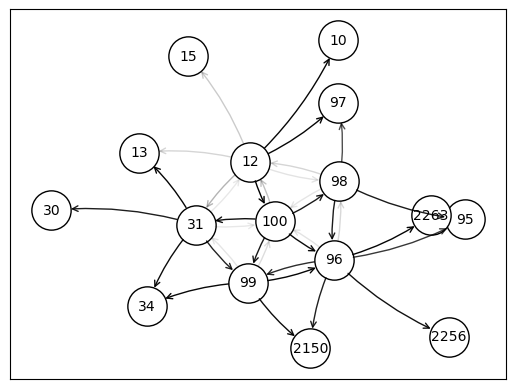

In [125]:
explanation.visualize_graph()

In [184]:
explanation.get_complement_subgraph()

Explanation(node_mask=[4975, 1], edge_mask=[29320], target=[4975, 1], index=[1], x=[4975, 47], edge_index=[2, 29320])

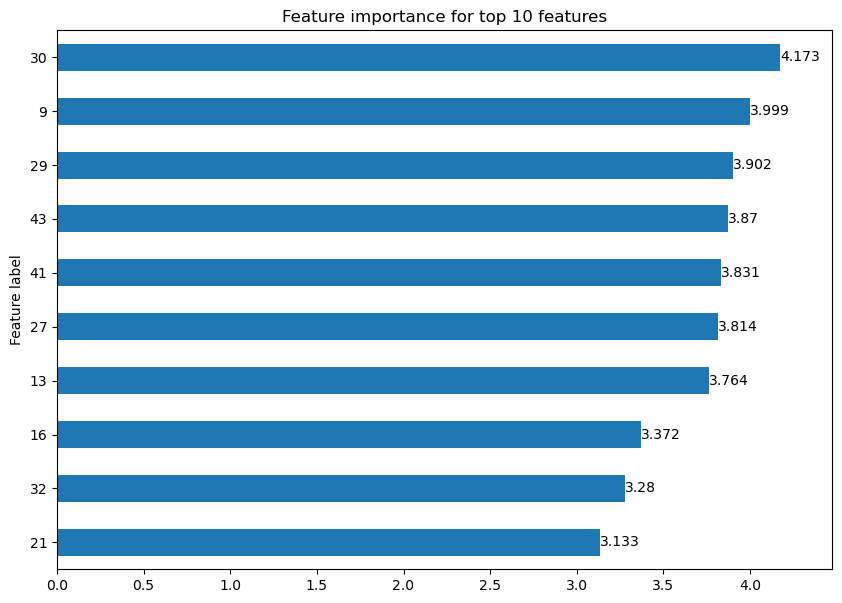

In [129]:
explanation.visualize_feature_importance(top_k=10)

In [76]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=4326, inplace=True)

# 检查和修复无效几何
gdf = gdf[gdf.is_valid]

# 假设您有解释子图的节点索引
subgraph_nodes = node_indices

# 从gdf中提取相关节点的几何信息
subgraph_gdf = gdf.loc[subgraph_nodes]

# 添加节点编号作为一列属性
subgraph_gdf['node_id'] = [804, 805, 931, 933, 934, 935, 939, 941, 942, 943, 946, 947, 948, 986, 989, 990, 992, 993, 997, 998, 1000, 1001, 1012, 1013, 1014, 1015, 1016, 1072, 1073, 1074, 1075, 1077, 1079, 1080, 1084, 4759]
# 生成唯一且不超过10个字符的列名
def unique_truncate(col_names):
    seen = set()
    new_col_names = []
    for col in col_names:
        new_col = col[:10]
        i = 1
        while new_col in seen:
            suffix = str(i)
            new_col = col[:10-len(suffix)] + suffix
            i += 1
        seen.add(new_col)
        new_col_names.append(new_col)
    return new_col_names

subgraph_gdf.columns = unique_truncate(subgraph_gdf.columns)

# 设置正确的文件编码
shapefile_path = "subgraph_nodes.shp"
subgraph_gdf.to_file(shapefile_path, encoding='utf-8')

# 保存 .prj 文件以确保坐标系信息
prj_text = gdf.crs.to_wkt()
with open(shapefile_path.replace('.shp', '.prj'), 'w') as prj_file:
    prj_file.write(prj_text)

print(f"Shapefile saved to {shapefile_path}")


Shapefile saved to subgraph_nodes.shp


In [108]:
subset

tensor([   0,    1,    2,    3,  875,  877,  878, 2569, 2570, 2571, 2589, 4066,
        4078, 4481, 4536, 4537, 4600, 4601, 4636])

In [130]:
model

GATv2(
  (conv1): GATv2Conv(47, 128, heads=1)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATv2Conv(128, 16, heads=1)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16, out_features=1, bias=True)
)

In [166]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import k_hop_subgraph, to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        conv1_out = x
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        conv2_out = x
        x = self.fc1(x)
        return conv1_out, conv2_out, x

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

# 假设 'data' 是一个预定义的 PyG 数据对象
node_idx = 0  # 目标节点
num_hops = 2

subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, num_hops, data.edge_index)

# 使用GNNExplainer获取节点和边的重要性
wrapped_model = WrappedModel(GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
))

explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

explanation = explainer(data.x, data.edge_index, index=node_idx)
A = explanation.get_explanation_subgraph()

# 获取节点和边的重要性
node_mask = A.node_mask
edge_mask = A.edge_mask

# 打印 node_mask 和 mapping 以检查其内容
print("Node mask:", node_mask)
print("Mapping:", mapping)

# 从 node_mask 中提取 subset 中节点的重要性值
# node_importance_values = node_mask.mean(dim=1)

# 设定阈值
node_importance_threshold = 0  # 设定节点重要性阈值

# 根据重要性阈值保留节点
important_nodes_mask = node_mask > node_importance_threshold

# 使用 subset 和 important_nodes_mask 来正确地从 node_mask 中提取重要节点
important_nodes = subset[important_nodes_mask[subset].nonzero(as_tuple=True)[0]].tolist()

# 打印 important_nodes 以检查其值
print("Important nodes:", important_nodes)

# 构建新的子图，保留所有边
G = to_networkx(data, to_undirected=True)
sub_G = G.subgraph(subset.tolist()).copy()

# 为每条边添加权重属性，所有边权重设为1
for u, v in sub_G.edges():
    sub_G[u][v]['weight'] = 1.0

# 获取子图中的节点列表
sub_nodes = list(sub_G.nodes)

# 节点的重要性（确保与子图中的节点匹配）
node_importance = [node_importance_values[subset.tolist().index(i)].item() for i in sub_nodes]

# 动态调整节点大小
node_sizes = [1000 * ni for ni in node_importance]

# 绘制图
pos = nx.spring_layout(sub_G)  # 使用 spring_layout 布局
edge_weights = [sub_G[u][v]['weight'] for u, v in sub_G.edges()]

nx.draw(sub_G, pos, with_labels=True, node_color='skyblue', edge_color='black', width=edge_weights, node_size=node_sizes)
plt.title("Subgraph with Important Nodes")
plt.show()


Node mask: tensor([[0.1781],
        [0.1583],
        [0.1380],
        [0.1387],
        [0.1414],
        [0.1478],
        [0.1517],
        [0.1548],
        [0.1478],
        [0.1605],
        [0.1348],
        [0.1507],
        [0.1526],
        [0.1492],
        [0.1385],
        [0.1279],
        [0.1284],
        [0.1564],
        [0.1380]])
Mapping: tensor([0])


IndexError: index 875 is out of bounds for dimension 0 with size 19

In [160]:
subset

tensor([   0,    1,    2,    3,  875,  877,  878, 2569, 2570, 2571, 2589, 4066,
        4078, 4481, 4536, 4537, 4600, 4601, 4636])

In [161]:
A

Explanation(node_mask=[19, 1], edge_mask=[37], prediction=[19, 1], target=[19, 1], index=[1], x=[19, 47], edge_index=[2, 37])

In [168]:
edge_index

tensor([[   0,    0,    0,    1,    1,    1,    1,    2,    2,    2,    3, 1688,
         2567, 2570, 2570, 2570, 2571, 2571, 4066, 4078, 4536, 4536, 4536, 4537,
         4537, 4601, 4601, 4636, 4636],
        [4536,    1,    2,    0, 4536,    2, 2570,    0,    1, 2570, 4536, 2570,
         2570,    1,    2, 4536,    2, 2570, 4536, 4536,    0,    1, 2570,    0,
         4536,    0,    2, 2570, 4536]])